In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset, DataLoader
import cv2
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

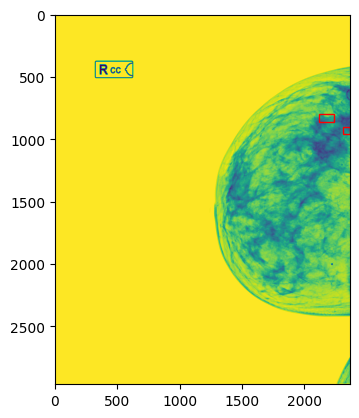

In [123]:
def parse_labels(file_path):
    labels = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            class_label = int(parts[0])
            x = float(parts[1])
            y = float(parts[2])
            x_width = float(parts[3])
            y_width = float(parts[4])
            labels.append((class_label, x, y, x_width, y_width))
    return np.array(labels)

def plot_bounding_boxes(image_path, label_path):
    # Load the image
    image = Image.open(image_path)

    # Load COCO format labels
    coco_labels = parse_labels(label_path)

    # Create a figure and axis
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Add bounding boxes to the image
    for annotation in coco_labels:
        bbox = annotation
        # COCO format: [x, y, width, height]
        class_, x, y, width, height = bbox
        x, y, width, height = x*image.width, y*image.height, width*image.width, height*image.height
        rect = patches.Rectangle((x-width, y-height), width*2, height*2, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Display the image with bounding boxes
    plt.show()

# Example usage
image_path = 'smallsetImage/Kategori4Sag_11773_RCC.png'
label_path = 'smallsetLabel/Kategori4Sag_11773_RCC.txt'  # Assuming the label file is in JSON format with COCO annotations
plot_bounding_boxes(image_path, label_path)

In [180]:
class MammogramDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        label = self.labels[idx]
        cord=[]
        if self.transform and len(label)>0:
            augmented = self.transform(image=image, bboxes=label[:,1:], class_labels=[0]*len(label))
            # print(label[:,1:])
            image = augmented['image']
            label=augmented["class_labels"]
            cord=augmented["bboxes"]
            # cord = clip_bboxes(cord)

        return image, label, cord


image_paths=["smallsetImage/"+dir for dir in os.listdir("smallsetImage")]
labels=[np.array(parse_labels("smallsetLabel/"+file)) for file in os.listdir("smallsetLabel")]


transform = A.Compose([
    A.RandomBrightnessContrast(contrast_limit=(0.3, 0.3), brightness_limit=(-0.4, -0.4), p=1.),
    A.Sharpen(p=1.),
    A.Rotate(limit=90, p=0.5),
    A.HorizontalFlip(p=0.3),
    ToTensorV2(),
],bbox_params=A.BboxParams(format="yolo",label_fields=["class_labels"],min_area=128))


dataset = MammogramDataset(image_paths, labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [181]:
# Directory to save the PNG files
save_dir = 'new'
os.makedirs(save_dir, exist_ok=True)

# Iterate through the DataLoader
names=os.listdir("smallsetImage")
for i, (image, label, cord) in enumerate(dataloader):
    # Convert the tensor to a NumPy array
    image = image.squeeze().numpy()  # Remove batch dimension and convert to numpy
    image = (image).astype(np.uint8)  # Convert from [0,1] to [0,255] range

    # Convert the NumPy array to a PIL image
    pil_image = Image.fromarray(image)

    # Save the image
    name=names[i][:-4]
    image_filename = f'{name}_aug.png'
    image_save_path = os.path.join(save_dir, image_filename)
    with open("transformed/"+image_filename[:-4]+".txt","w") as file:
        for coordinate in cord:
            x, y, width, height=coordinate
            text_label=f"0 {x.item()} {y.item()} {width.item()} {height.item()}\n"
            file.write(text_label)

    pil_image.save(image_save_path)
    print(f'Saved {image_save_path}')


c:\Users\alt_user\AppData\Local\Programs\Python\Python311\Lib\site-packages\albucore\utils.py:113: UserWarning: HueSaturationValue: hue_shift and sat_shift are not applicable to grayscale image. Set them to 0 or use RGB image
  result = func(img, *args, **kwargs)


Saved new\Kategori4Sag_11770_RMLO_aug.png
Saved new\Kategori4Sag_11771_RCC_aug.png
Saved new\Kategori4Sag_11771_RMLO_aug.png
Saved new\Kategori4Sag_11772_RCC_aug.png
Saved new\Kategori4Sag_11772_RMLO_aug.png
Saved new\Kategori4Sag_11773_RCC_aug.png
Saved new\Kategori4Sag_11773_RMLO_aug.png
Saved new\Kategori4Sag_11774_RCC_aug.png
Saved new\Kategori4Sag_11774_RMLO_aug.png
Saved new\Kategori4Sag_11775_RCC_aug.png
Saved new\Kategori4Sag_11775_RMLO_aug.png
Saved new\Kategori4Sag_11776_RCC_aug.png
Saved new\Kategori4Sag_11776_RMLO_aug.png
Saved new\Kategori4Sag_11777_RCC_aug.png
Saved new\Kategori4Sag_11777_RMLO_aug.png
Saved new\Kategori4Sag_11778_RCC_aug.png
Saved new\Kategori4Sag_11778_RMLO_aug.png
Saved new\Kategori4Sag_11779_RCC_aug.png
Saved new\Kategori4Sag_11779_RMLO_aug.png
Saved new\Kategori4Sag_11780_RCC_aug.png
Saved new\Kategori4Sag_11780_RMLO_aug.png
Saved new\Kategori4Sag_11781_RCC_aug.png
Saved new\Kategori4Sag_11781_RMLO_aug.png
Saved new\Kategori4Sag_11782_RCC_aug.png
Save

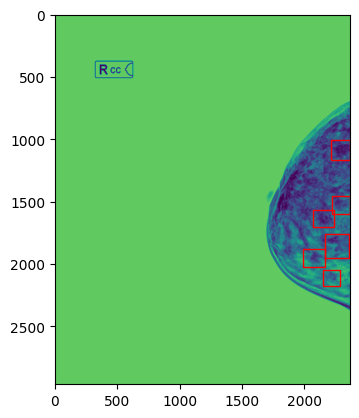

In [179]:
image_path = 'new/image_15.png'
label_path = 'transformed/image_15.txt'  # Assuming the label file is in JSON format with COCO annotations
plot_bounding_boxes(image_path, label_path)